In [421]:
reset -f

In [422]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import time

In [423]:
def preprocess():
    os.chdir('C:\\Users\\s106961\\Desktop\\Deep Learning\\Data')
    with h5py.File('train_128.h5','r') as H:
        data = np.copy(H['data'])
    with h5py.File('train_label.h5','r') as H:
        label = np.copy(H['label'])
    mu = data.mean()
    sigma = data.std()
    data = (data - mu) / sigma

    return data, label

data, label = preprocess()

In [424]:
def mini_batch(X,y,iteration,batch_size = 100, shuffle = False):
    dim = len(y)
    idx = np.array(range(0,dim)).astype(np.int)
    if shuffle == True: 
        np.random.shuffle(idx)
        start = 0
        end = batch_size
    else:
        start = (iteration * batch_size) % dim
        end = start + batch_size
        
    X = X[idx[start:end]]
    y = y[idx[start:end]]
    return X, y

def weight_init(X, y, hidden_units):
    
    Weights = {}
    Bias = {}
    no_hidden = len(hidden_units)
    no_features = X.shape[1]
    for n, units in enumerate(hidden_units):
        Weights['layer_{}'.format(n+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(no_features, units))
        Bias['layer_{}'.format(n+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(units))
        no_features = units
    
    labels = len(np.unique(y))
    Weights['layer_{}'.format(no_hidden+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)), high=np.sqrt(2. / (no_features)),size=(no_features, labels))
    Bias['layer_{}'.format(no_hidden+1)] = np.random.uniform(low=-np.sqrt(2. / (no_features)),high=np.sqrt(2. / (no_features)),size=(labels))
    
    return Weights, Bias 

In [437]:
def sigmoid(inp):
    return (1/(1 + np.exp(-inp)))

def tanh(inp):
    return (np.exp(inp) - np.exp(-inp))/(np.exp(inp) + np.exp(-inp))

def relu(inp):
    return np.maximum(inp,0)

def softmax(inp):
    #op_exp = np.exp(inp)
    #return op_exp/op_exp.sum(axis = 1)[:,None]
    
    #the above code causes overflow. The below one is normalised.
    inp_max = inp.max()
    inp_norm = inp - inp_max
    return np.exp(inp_norm) / np.sum(np.exp(inp_norm), axis=1) [:,None]

def leaky_relu(inp):
    return np.maximum(inp,0.1*inp)  
   
activation_fn = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu, 'leaky_relu': leaky_relu}

def gradient_sigmoid(inp):
    return sigmoid(inp) * (1 - sigmoid(inp))

def gradient_tanh(inp):
    return (1 -tanh(inp)) * (1 + tanh(inp))

def gradient_relu(inp):
    inp[inp>0] = 1
    inp[inp<0] = 0
    return inp

def gradient_leaky_relu(inp):
    inp[inp<0] = 0.1
    inp[inp>=0] = 1
    return inp
    
gradient_fn = {'sigmoid': gradient_sigmoid, 'tanh': gradient_tanh, 'relu': gradient_relu, 'leaky_relu':gradient_leaky_relu}

def output_label_hot_encode_old(inp):
    inp = inp.astype(int)
    classes = np.unique(inp)
    no_classes = classes.shape[0]
    no_dim = inp.shape[0]
    zero_arr = np.zeros((no_dim, no_classes))
    zero_arr[np.arange(no_dim), inp] = 1.0
    return zero_arr

def output_label_hot_encode(inp,batch_size,no_label):
    one_hot_array = np.zeros((batch_size,no_label))
    one_hot_array[np.arange(batch_size),inp] = 1
    return one_hot_array

def cross_entropy_error(y_act, y_hat):
    return np.sum(np.multiply(y_act, np.log(y_hat)) * -1)

def accuracy(y_hat, y_act):
    return round((np.sum((y_hat.argmax(axis=1) == y_act.argmax(axis=1)))/y_act.shape[0] * 100),2)

def predict(data, label, Weights, Bias, no_hidden = 2, activation = 'relu'):
    layers, y_hat = forward_propagation(data, label, Weights, Bias, no_hidden, activation,dropout_units = None, predict =True)
    y_act = output_label_hot_encode(label, data.shape[0], no_label = 10)
    return y_hat, y_act

In [445]:
def forward_propagation(X, y, Weights, Bias, no_hidden, activation, dropout_units, predict = False):
    
    layers = {}
    layers['layer_{}'.format(0)] = X #input layer
    if predict == False:
        layers['layer_{}'.format(0)][:,dropout_units['layer_{}'.format(0)]] = 0

    for l in range(no_hidden):
        layers['layer_wx_{}'.format(l+1)] = np.matmul(layers['layer_{}'.format(l)], Weights['layer_{}'.format(l+1)]) + Bias['layer_{}'.format(l+1)]
        layers['layer_{}'.format(l+1)] = activation_fn[activation](layers['layer_wx_{}'.format(l+1)])
        
        if predict == False:
            layers['layer_wx_{}'.format(l+1)][:,dropout_units['layer_{}'.format(l+1)]] = 0
            layers['layer_{}'.format(l+1)][:,dropout_units['layer_{}'.format(l+1)]] = 0
        
    layers['layer_wx_{}'.format(no_hidden+1)] = np.matmul(layers['layer_{}'.format(no_hidden)], Weights['layer_{}'.format(no_hidden+1)])
    layers['layer_{}'.format(no_hidden+1)] = softmax(layers['layer_wx_{}'.format(no_hidden+1)])
    
    y_hat = layers['layer_{}'.format(no_hidden+1)]
        
    return (layers, y_hat)

In [439]:
def backward_propagation(layers, y_act, y_hat, Weights, Bias, no_hidden, activation):
    
    gradients = {}
    dim = y_act.shape[0]
    
    gradients['dL/dA_layer_{}'.format(no_hidden+1)]  = ((y_act - y_hat) * -1)/dim
    
    for i in range(no_hidden,-1,-1):
        
        gradients['dL/dW_layer{}'.format(i+1)] = np.zeros(Weights['layer_{}'.format(i+1)].shape)
        for j in range(Weights['layer_{}'.format(i+1)].shape[0]):
            for k in range(Weights['layer_{}'.format(i+1)].shape[1]):
                gradients['dL/dW_layer{}'.format(i+1)][j][k] = np.sum((np.multiply(gradients['dL/dA_layer_{}'.format(i+1)][:,k], layers['layer_{}'.format(i)][:,j])))
                
        gradients['dL/dB_layer{}'.format(i+1)] = np.sum(gradients['dL/dA_layer_{}'.format(i+1)],axis=0)
        if i != 0:
            gradients['dL/dH_layer{}'.format(i)] = np.matmul(gradients['dL/dA_layer_{}'.format(i+1)],np.transpose(Weights['layer_{}'.format(i+1)]))
            gradients['dL/dA_layer_{}'.format(i)] = gradient_fn[activation](layers['layer_wx_{}'.format(i)]) * gradients['dL/dH_layer{}'.format(i)]
    
    return gradients

In [440]:
def gradient_descent(gradients, Weights, Bias, learning_rate,no_hidden):
    for i in range(no_hidden+1,0,-1):
        Weights['layer_{}'.format(i)] = Weights['layer_{}'.format(i)] - (learning_rate * gradients['dL/dW_layer{}'.format(i)])
        Bias['layer_{}'.format(i)] = Bias['layer_{}'.format(i)] - (learning_rate * gradients['dL/dB_layer{}'.format(i)])
        
    return Weights, Bias

def momentum_gradient_descent(gradients, Weights, Bias, learning_rate,no_hidden, rho, prev_gradients):
    momentum_gradient = {}
    for i in range(no_hidden+1,0,-1):
        momentum_gradient['dL/dW_layer{}'.format(i)] = (rho * prev_gradients['dL/dW_layer{}'.format(i)]) + (learning_rate * gradients['dL/dW_layer{}'.format(i)])
        momentum_gradient['dL/dB_layer{}'.format(i)] = (rho * prev_gradients['dL/dB_layer{}'.format(i)]) + (learning_rate * gradients['dL/dB_layer{}'.format(i)])
        Weights['layer_{}'.format(i)] = Weights['layer_{}'.format(i)] - momentum_gradient['dL/dW_layer{}'.format(i)]
        Bias['layer_{}'.format(i)] = Bias['layer_{}'.format(i)] - momentum_gradient['dL/dB_layer{}'.format(i)]
        
    return Weights, Bias, momentum_gradient

def adam(gradients, Weights, Bias, learning_rate,no_hidden, prev_gradients, prev_velocity, beta1, beta2, time):
    momentum_gradient = {}
    velocity = {}
    ephsilon = 1e-5
    for i in range(no_hidden+1,0,-1):
        momentum_gradient['dL/dW_layer{}'.format(i)] = ((beta1 * prev_gradients['dL/dW_layer{}'.format(i)]) + ((1-beta1) * gradients['dL/dW_layer{}'.format(i)]))#/(1-beta1**time)
        momentum_gradient['dL/dB_layer{}'.format(i)] = ((beta1 * prev_gradients['dL/dB_layer{}'.format(i)]) + ((1-beta1) * gradients['dL/dB_layer{}'.format(i)]))#/(1-beta1**time)
        velocity['dL/dW_layer{}'.format(i)] = (beta2 * prev_velocity['dL/dW_layer{}'.format(i)]) + ((1-beta2) * np.square(gradients['dL/dW_layer{}'.format(i)]))#/(1-beta2**time)
        velocity['dL/dB_layer{}'.format(i)] = (beta2 * prev_velocity['dL/dB_layer{}'.format(i)]) + ((1-beta2) * np.square(gradients['dL/dB_layer{}'.format(i)]))#/(1-beta2**time)
        
        Weights['layer_{}'.format(i)] = Weights['layer_{}'.format(i)] - ((learning_rate * momentum_gradient['dL/dW_layer{}'.format(i)])/(np.sqrt(velocity['dL/dW_layer{}'.format(i)]) + ephsilon))
        Bias['layer_{}'.format(i)] = Bias['layer_{}'.format(i)] - ((learning_rate * momentum_gradient['dL/dB_layer{}'.format(i)])/(np.sqrt(velocity['dL/dB_layer{}'.format(i)]) + ephsilon))

    return Weights, Bias, momentum_gradient, velocity

In [441]:
def dropout(input_features, hidden_units, input_layer_ratio = 0.8, hidden_layer_ratio = 0.5):
    
    dropout_units = {}
    drop_units = np.arange(input_features)
    np.random.shuffle(drop_units)
    dropout_units['layer_{}'.format(0)] = drop_units[:int(input_features * (1-input_layer_ratio))]

    for (i, units) in enumerate(hidden_units,1):
        drop_units = np.arange(units)
        np.random.shuffle(drop_units)
        dropout_units['layer_{}'.format(i)] = drop_units[:int(units * (1-hidden_layer_ratio))]
    return dropout_units

In [454]:
def train(data, label, hidden_units, Weights, Bias, activation = 'sigmoid', descent_method = 'momentum_gradient_descent', 
          epochs = 10000, learning_rate = 0.01,batch_size = 100):
    
    start = time.time()    
    error = []   
    no_hidden = len(hidden_units)
    no_label = len(np.unique(label))
    input_features = data.shape[1]
    rho = 0.9
    beta1 = 0.9
    beta2 = 0.999

    for i in range(epochs):
        dropout_units = dropout(input_features, hidden_units, input_layer_ratio = 0.8, hidden_layer_ratio = 0.5)
        X, y = mini_batch(data,label,i,batch_size,shuffle = False)
        y_act = output_label_hot_encode(y, batch_size, no_label)
        layers, y_hat = forward_propagation(X, y, Weights, Bias, no_hidden, activation, dropout_units)
        gradients = backward_propagation(layers, y_act, y_hat, Weights, Bias, no_hidden, activation)
        
        if descent_method == 'gradient_descent':
            Weights, Bias = gradient_descent(gradients, Weights, Bias, learning_rate, no_hidden)
        elif descent_method == 'momentum_gradient_descent':
            if i == 0:
                prev_gradients = {layer:gradients[layer] * 0 for layer in gradients}
            Weights, Bias, prev_gradients = momentum_gradient_descent(gradients, Weights, Bias, learning_rate, no_hidden,
                                                                      rho, prev_gradients)
        elif descent_method == 'adam':
            if i == 0:
                prev_gradients = {layer:gradients[layer] * 0 for layer in gradients}
                prev_velocity = {layer:gradients[layer] * 0 for layer in gradients}
            Weights, Bias, prev_gradients, prev_velocity = adam(gradients, Weights, Bias, learning_rate,no_hidden, 
                                                  prev_gradients, prev_velocity, beta1, beta2, time = i+1)
            
        ce_error = cross_entropy_error(y_act, y_hat)
        
        if i%100 == 0: error.append(ce_error)
        if i%100 == 0: 
            pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
            print('Epoch:' + str(i) + ' Error:' + str(round(ce_error,2)) + ' Accuracy:' + str(accuracy(pred_y_hat, pred_y_act)))
        
    end = time.time()
    print('Training time: ' + str(round((end - start)/60)) + ' mins')
    return error, y_act, y_hat, Weights, i

In [461]:
hidden_units = [50,25]
no_hidden = len(hidden_units)
Weights, Bias = weight_init(data, label, hidden_units)

Epoch:0 Error:233.04 Accuracy:20.67
Epoch:100 Error:184.26 Accuracy:70.28
Epoch:200 Error:115.34 Accuracy:73.87
Epoch:300 Error:127.94 Accuracy:77.71
Epoch:400 Error:115.19 Accuracy:79.29
Epoch:500 Error:108.3 Accuracy:76.87
Epoch:600 Error:110.74 Accuracy:80.06
Epoch:700 Error:66.66 Accuracy:80.26
Epoch:800 Error:78.28 Accuracy:81.08
Epoch:900 Error:107.76 Accuracy:82.0
Epoch:1000 Error:167.32 Accuracy:81.61
Epoch:1100 Error:90.44 Accuracy:82.07
Epoch:1200 Error:78.9 Accuracy:81.49
Epoch:1300 Error:74.28 Accuracy:81.0
Epoch:1400 Error:60.47 Accuracy:81.9
Epoch:1500 Error:101.02 Accuracy:82.24
Epoch:1600 Error:91.58 Accuracy:82.4
Epoch:1700 Error:104.98 Accuracy:82.43
Epoch:1800 Error:72.68 Accuracy:82.04
Epoch:1900 Error:57.7 Accuracy:82.66
Epoch:2000 Error:101.99 Accuracy:82.87
Epoch:2100 Error:79.98 Accuracy:83.43
Epoch:2200 Error:80.9 Accuracy:82.88
Epoch:2300 Error:94.41 Accuracy:83.16
Epoch:2400 Error:87.67 Accuracy:82.81
Epoch:2500 Error:74.82 Accuracy:83.08
Epoch:2600 Error:98.

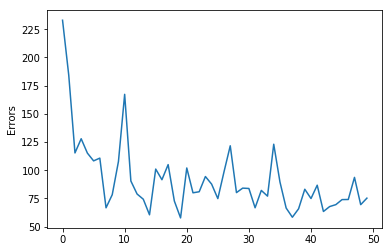

In [462]:
error, y_act, y_hat, Weight_new, iters = train(data, label, hidden_units, Weights, Bias, activation = 'relu',
                                               descent_method = 'adam', epochs = 5000, 
                                               learning_rate = 0.01,batch_size = 100)
pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
print('Accuracy ' + str(accuracy(pred_y_hat, pred_y_act)))
plt.plot(error)
plt.ylabel('Errors')
plt.show()

In [255]:
pred_y_hat, pred_y_act = predict(data, label, Weights, Bias, no_hidden, activation = 'relu')
print('Accuracy ' + str(accuracy(pred_y_hat, pred_y_act)))

Accuracy 80.91
